In [1]:
import numpy as np
import pandas as pd
import spacy
import networkx as nx
import score as sc
import time
from sklearn.metrics import confusion_matrix, pairwise, f1_score, precision_score
from scipy.spatial import distance
from preprocessing.utils import plot_confusion_matrix
import matplotlib.pyplot as plt
import nltk
from collections import Counter, defaultdict
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import itertools
import torch
import importlib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import pickle
import sentic

In [2]:
import sys
importlib.reload(sys.modules['preprocessing.utils'])
from preprocessing.utils import plot_confusion_matrix

In [3]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix_local(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax

In [4]:
#https://github.com/huggingface/neuralcoref
#note: this NEEDS spacy 2.0.12 to work! downgrade with pip install spacy=2.0.12
import en_coref_md
nlp = spacy.load('en_core_web_sm')
coref = en_coref_md.load()

In [5]:
negating_words = set([
    "n't", "not", "no", 
    "never", "nobody", "non", "nope"])
doubting_words = set([
    'fake','fraud', 'hoax', 
    'false', 'deny', 'denies', 
    'despite', 'doubt', 
    'bogus', 'debunk', 'prank', 
    'retract', 'scam', "withdrawn",
    "misinformation"])
hedging_words = set([
    'allege', 'allegedly','apparently',
    'appear','claim','could',
    'evidently','largely','likely',
    'mainly','may', 'maybe', 'might',
    'mostly','perhaps','presumably',
    'probably','purport', 'purportedly',
    'reported', 'reportedly',
    'rumor', 'rumour', 'rumored', 'rumoured',
    'says','seem','somewhat',
    'unconfirmed'])
sus_words = doubting_words.union(hedging_words)

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

def get_sentiment(sentence):
    sent =  vader.polarity_scores(sentence.text)
    return [sent["pos"],sent["neg"],sent["neu"],sent["compound"]]

def get_avg_sentiment(lst):
    sents = np.array([get_sentiment(s) for s in lst])
    return list(np.mean(sents, axis = 0))

def get_diff_sentiment(a,b):
    return list(np.absolute(np.array(a) - np.array(b)))

In [7]:
def train_test_split(bodies, stances, split=0.8):
    idx = np.random.permutation(np.arange(len(bodies)))
    bodies = bodies.values[idx]
    train = int(len(bodies)*0.8)
    bodies_tr = set([i[0] for i in bodies[:train]])
    bodies_val = set([i[0] for i in bodies[train:]])
    stances_tr = stances.loc[stances["Body ID"].isin(bodies_tr), :]
    stances_val = stances.loc[stances["Body ID"].isin(bodies_val), :]
    return stances_tr, stances_val

In [8]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head(15)

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss
11,Woman detained in Lebanon is not al-Baghdadi's...,1468,agree
14,"Soon Marijuana May Lead to Ticket, Not Arrest,...",47,discuss
16,Boko Haram Denies Nigeria Cease-Fire Claim,2463,discuss
17,"No, Robert Plant Didn’t Rip Up an $800 Million...",295,agree
19,ISIL Beheads American Photojournalist in Iraq,608,discuss


In [9]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [10]:
def get_body(n):
    return train_bodies.loc[lambda x: x["Body ID"] == n, "articleBody"].item()

In [11]:
def preprocess(text):
    text = text.replace("' ",' ')
    text = text.replace(" '",' ')
    text = text.replace(":", ". ")
    text = text.replace(";", ". ")
    return text

In [12]:
def cosine_similarity(x,y):
    return 1 - np.nan_to_num(distance.cosine(x,y))

In [13]:
def get_topics(doc):
    """
    get topics of a sentence
    input: spacy doc
    output: dictionary with nouns as the key, and the set of noun chunks that contain the noun as the value
    special entry _vocab has the set of all tokens in the dict
    """
    subjs = {}
    for token in doc:
        if token.dep_ in ["nsubj", "nsubjpass", "csubj","csubjpass", "dobj", "dative", "attr", "oprd", "pobj", "compound"]:
            txt = token.lemma_.lower()
            if txt not in subjs:
                subjs[txt] = set([txt])      
    for chunk in doc.noun_chunks:
        if len(chunk.root.text) > 2:
            txt = chunk.root.text.lower()
            if txt not in subjs:
                subjs[txt] = set([txt])
            subjs[txt].add(chunk.text.lower())
    subjects_= []
    for word in subjs:
        for phrase in subjs[word]:
            subjects_ += phrase.split(" ")
    subjs["_vocab"] = set(subjects_)
    return subjs

In [14]:
def get_svos(sent):
    """
    input: Spacy processed sentence
    output: dict of subj, dict of v, dict of obj (each word is lemmatized and lowercased)
    each entry in dict has key of lemmatized token, value is actual token (to do traversals with later if needed)
    """
    s = {}
    v = {}
    o = {}
    for token in sent:
        if token.dep_ == 'ROOT':
            v[token.lemma_.lower()] = token
        elif token.dep_ in ["nsubj", "nsubjpass", "csubj","csubjpass", "agent","compound"]:
            s[token.lemma_.lower()] = token
        elif token.dep_ in ["dobj", "dative", "attr", "oprd", "pobj"]:
            o[token.lemma_.lower()] = token
    # https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md
    return (s,v,o)

In [15]:
from sentic import SenticPhrase
text = "Hello, World!"
sp = SenticPhrase(text)

def get_sentics(sent):
    """
        input: Spacy processed sentence
        output: a tuple containing the polarity score and a list of sentic values 
            (pleasantness, attention, sensitiviy, aptitude )
    """
    sent = (str(sent)).strip().replace("'", "")
    info = sp.info(sent)
          
    # Sometimes sentic doesn't returns any sentics values, seems to be only when purely neutral. 
    # Some sort of tag to make sure this is true could help with classiciation! (if all 0's not enough)
    if(len(info["sentics"].values())==0):
          info["sentics"] = {"pleasantness":0, "attention":0, "sensitiviy":0, "aptitude":0}
    return info['polarity'], info["sentics"].values()

In [16]:
def build_graph(doc):
    """
    build a NetworkX graph of the dependency tree
    input: spacy Doc
    output: networkx graph
    """
    edges = set()
    for token in doc:
        if token.pos_ not in ['PUNCT', 'NUM', 'SYM','SPACE','PART']:
            for child in token.children:
                if child.pos_ not in ['PUNCT', 'NUM', 'SYM','SPACE','PART']:
                    edges.add((token.lemma_.lower(),child.lemma_.lower()))
    graph = nx.DiGraph(list(edges))
    return graph

In [17]:
def get_summary(doc, subjects, n = 5):
    """
    get summary of n sentences in document
    first meaningful sentence will always be returned
    """
    subjects_ = subjects["_vocab"]
    def score_sentence(sent):
        # not very robust right now
        score = 0
        word_count = 0
        for token in sent:
            word_count += 1
            t = token.lemma_.lower()
            if t in subjects_:
                score += 1
            elif t in negating_words or t in doubting_words or t in hedging_words:
                score += 0.5
            return score/word_count if word_count > 4 else 0
    sentences = [s for s in doc.sents]
    scored_sentences = [[idx, sent, score_sentence(sent)] for idx, sent in enumerate(sentences)]
    scored_sentences = [s for s in scored_sentences if s[2] > 0] #filter out non-scoring sentences
    scored_sentences.sort(key = lambda x: x[2], reverse = True)
    top = scored_sentences[:n-1]
    top.sort(key = lambda x: x[0])
    scored_sentences.sort(key = lambda x: x[0])
    result = None
    if len(scored_sentences) == 0:
        result = [sentences[0]]
    else:
        result = [scored_sentences[0][1]] + [s[1] for s in top]
    return result

In [18]:
def get_shortest_path_to_negating(graph, subjects):
    """
    get the shortest path from each subject to any negating or doubting/hedging word
    returns: dictionary with subject as key, and 2-element list of path lengths [negating, doubting]
    - if a subject does not exist in graph or have a path to any negating word, then the value will be [None, None]
    """
    results = {}
    for s in subjects:
        results[s] = [None, None]
        if graph.has_node(s):
            for word in negating_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][0] == None or len(path) < results[s][0]:
                            results[s][0] = len(path)
                    except:
                        continue
            for word in sus_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][1] == None or len(path) < results[s][1]:
                            results[s][1] = len(path)
                    except:
                        continue
    return results

In [19]:
def root_distance(graph, root):
    """
    as implemented in the Emergent paper - return the shortest distance between the given root and any 
    doubting or hedging words in the graph, or None if no such path exists
    """
    if root == None:
        return None
    min_dist = None
    for word in sus_words:
        if word in graph:
            try:
                path = nx.shortest_path(graph, source = root, target = word)
                if min_dist == None or len(path) < min_dist:
                    min_dist = len(path)
            except:
                continue
    return min_dist

In [20]:
def get_neg_ancestors(doc):
    """
    get the ancestors of every negating word
    input: spacy Doc
    returns: tuple  - set of words that were in the ancestor list of negating words, 
    set of words that were in ancestor list of refuting words, # negating words, # refuting words
    """
    results = [set(), set(), 0, 0]
    for token in doc:
        if token.lemma_.lower() in negating_words:
            results[0] = results[0].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2])
            )
            results[2] += 1
        elif token.lemma_.lower() in sus_words:
            results[1] = results[1].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2])
            )
            results[3] += 1
    return tuple(results)

In [21]:
# h_id = 25
# df = agrees
# test = nlp(preprocess(list(df.values)[h_id][0]))
# print(test)
# test_graph = build_graph(test)
# test_subj = get_topics(test)
# test_svo = get_svos(test)
# print(get_shortest_path_to_negating(test_graph, test_subj))
# print(test_subj, test_svo, list(test_svo[1].keys())[0])
# print(root_distance(test_graph, list(test_svo[1].keys())[0]))
# print(get_neg_ancestors(test))

In [22]:
# body_text = get_body(list(df.values)[h_id][1])
# body = coref(preprocess(body_text))
# resolved = body._.coref_resolved.lower()
# body = nlp(resolved)
# body_graph = build_graph(body)
# summary = get_summary(body, test_subj, 5)
# for s in summary:
#     svo_s = get_svos(s)
#     print(get_shortest_path_to_negating(body_graph, test_subj))
#     print(svo_s)
#     print(root_distance(body_graph, list(svo_s[1].keys())[0]))
#     print(get_neg_ancestors(s))
#     print("")

# Preprocess headline and body

In [23]:
def preprocess_graph():
    headline_info = {}
    body_info = {}
    start = time.time()
    stance_data = list(train_stances.values)
    body_data = list(train_bodies.values)
    for headline in range(len(stance_data)):
        if headline % 2500 == 0:
            print("Processed "+str(headline))
        h, b_id, s = tuple(stance_data[headline])
        if h not in headline_info:
            nlp_h = nlp(preprocess(h))
            headline_graph = build_graph(nlp_h)
            headline_subj = get_topics(nlp_h)
            headline_svo = get_svos(nlp_h)
            headline_root_dist = root_distance(headline_graph, list(headline_svo[1].keys())[0])
            headline_neg_ancestors = get_neg_ancestors(nlp_h)
            nqh = 0
            for tok in nlp_h:
                if tok.text == "?":
                    nqh += 1
            headline_info[h] = (nlp_h, headline_graph, headline_subj, headline_svo, headline_root_dist, headline_neg_ancestors, nqh)
    print("Done with headlines!")
    for body in range(len(body_data)):
        if body % 100 == 0:
            print("Processed "+str(body))
        b_id, txt = tuple(body_data[body])
        txt = preprocess(txt)
        nlp_a = coref(preprocess(txt))
        nlp_b = nlp(nlp_a._.coref_resolved.lower())
        body_graph = build_graph(nlp_b)
        nqb = 0
        for tok in nlp_b:
            if tok.text == "?":
                nqb += 1
        body_info[b_id] = (nlp_b, body_graph, nqb)
    print("Done!")
    end = time.time()
    print(int(end-start))
    return headline_info, body_info

In [24]:
headline_info = None
body_info = None
try:
    with open('saved_data/headline_data.pkl', 'rb') as pkl_data:
        headline_info = pickle.load(pkl_data)
    with open('saved_dat/body_data.pkl', 'rb') as pkl_data:
        body_info = pickle.load(pkl_data)
    print("Had pickled files already, no problemo")
except:
    headline_info, body_info = preprocess_graph()
    with open('saved_data/headline_data.pkl', 'wb') as pkl_data:
        pickle.dump(headline_info, pkl_data)
    with open('saved_data/body_data.pkl', 'wb') as pkl_data:
        pickle.dump(body_info, pkl_data)
    print("Generated train/test data and created pickle files for future use.")

Processed 0
Processed 2500
Processed 5000
Processed 7500
Processed 10000
Processed 12500
Done with headlines!
Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900
Processed 1000
Processed 1100
Processed 1200
Processed 1300
Processed 1400
Processed 1500
Processed 1600
Done!
1040


TypeError: no default __reduce__ due to non-trivial __cinit__

In [25]:
import json
body_graphs = {}
for i in body_info:
    body_graphs[i] = list(body_info[i][1].edges())
with open('saved_data/body_graphs.json', 'w') as fp:
    json.dump(body_graphs, fp)
    
headline_graphs = {}
for i in headline_info:
    headline_graphs[i] = list(headline_info[i][1].edges())
with open('saved_data/headline_graphs.json', 'w') as fp:
    json.dump(headline_graphs, fp)

In [26]:
def get_sentence_vec(s):
    vecs = [token.vector for token in s]
    return np.nan_to_num(np.sum(vecs, axis = 0))

def get_features(stance_df, n_sent = 5):
    start = time.time()
    data = list(stance_df.values)
    features = []
    actual = []
    for item in data:
        h, b, s = tuple(item)
        headline, headline_graph, headline_subjs, headline_svo, headline_root_dist, headline_neg_ancestors, nq_h  = headline_info[h]
        body, body_graph, nq_b = body_info[b]
        
        #sometimes the coref deletes bodies that are one sentence
        if len(body) == 0:
            body = nlp(preprocess(get_body(b)))
            body_graph = build_graph(body)

        #return the shortest path to negating word for each subject in headline_subjs, if one exists
        neg_h = get_shortest_path_to_negating(headline_graph, headline_subjs)
        neg_b = get_shortest_path_to_negating(body_graph, headline_subjs)

        #body summary
        summary = get_summary(body, headline_subjs, n_sent)
        first_summ_sentence = summary[0]
        
        summary_svos = [get_svos(s) for s in summary]
        summary_root_dist = [root_distance(body_graph, list(s[1].keys())[0]) for s in summary_svos]
        summary_neg_ancestors = [get_neg_ancestors(s) for s in summary]
        summary_neg_counts = [s[2:] for s in summary_neg_ancestors]
        
        #svo
        body_s, body_v, body_o = {}, {}, {}
        headline_s, headline_v, headline_o = headline_svo
        for svo in summary_svos:
            body_s.update(svo[0])
            body_v.update(svo[1])
            body_o.update(svo[2])
        body_s_vec = list(np.sum([body_s[s].vector for s in body_s], axis = 0)) if len(body_s) > 0 else np.zeros(384)
        body_v_vec = list(np.sum([body_v[s].vector for s in body_v], axis = 0)) if len(body_v) > 0 else np.zeros(384)
        body_o_vec = list(np.sum([body_o[s].vector for s in body_o], axis = 0)) if len(body_o) > 0 else np.zeros(384)
    
        headline_s_vec = list(np.sum([headline_s[s].vector for s in headline_s], axis = 0)) if len(headline_s) > 0 else np.zeros(384)
        headline_v_vec = list(np.sum([headline_v[s].vector for s in headline_v], axis = 0)) if len(headline_v) > 0 else np.zeros(384)
        headline_o_vec = list(np.sum([headline_o[s].vector for s in headline_o], axis = 0)) if len(headline_o) > 0 else np.zeros(384)
        
        cos_sim_s = cosine_similarity(body_s_vec, headline_s_vec)
        cos_sim_v = cosine_similarity(body_v_vec, headline_v_vec)
        cos_sim_o = cosine_similarity(body_o_vec, headline_o_vec)
        
        #negating paths
        headline_paths = [neg_h[x] for x in neg_h]
        headline_neg_paths = [1 if x[0] != None else 0 for x in headline_paths] + [1]
        headline_hedge_paths = [1 if x[1] != None else 0 for x in headline_paths] + [1]
        body_paths = [neg_h[x] for x in neg_h]
        body_neg_paths = [1 if x[0] != None else 0 for x in body_paths] + [1]
        body_hedge_paths = [1 if x[1] != None else 0 for x in body_paths] + [1]
        
        neg_path_cos_sim = cosine_similarity(headline_neg_paths, body_neg_paths)
        hedge_path_cos_sim = cosine_similarity(headline_hedge_paths, body_hedge_paths)
        
        #root distance
        avg_summary_root_dist = None
        non_null = [x for x in summary_root_dist if x != None]
        if len(non_null) != 0:
            avg_summary_root_dist = sum(non_null)/len(non_null)
        root_dist_feats = [headline_root_dist, avg_summary_root_dist]
        root_dist_feats = [x if x != None else 100 for x in root_dist_feats]
    
        #sentiment
        headline_sent = get_sentiment(headline)
        body_sents = [get_sentiment(s) for s in summary]
        diff_sents = list(np.sum([get_diff_sentiment(headline_sent, s) for s in body_sents], axis = 0))
        
        #polarity
        
        headline_polar, headline_sentic = get_sentics(headline)
        body_polars = [0 for s in range(len(summary))]
        body_sentics = [[] for s in range(len(summary))]
        for s in range(len(summary)): 
            body_polars[s], body_sentics[s] = get_sentics(summary[s])
            body_sentics[s] = np.array(list(body_sentics[s]))
        #body_sentics = np.mean(body_sentics, axis=0)
        headline_sentic = (list(headline_sentic))
        # Right now just an array of differences across each sentence, could be just the average
        diff_polars = [np.absolute(headline_polar - s) for s in body_polars]
        diff_sentics = list(np.sum([get_diff_sentiment(headline_sentic, s) for s in body_sentics], axis = 0))
        #print(f'Diff Polar:${diff_polars} Diff Sentics:{diff_sentics}')
        """print(headline, summary)
        print('headline sent', headline_sentic)
        print('diff sent', diff_sentics)
        print('headline_polar', headline_polar)
        print("diff polars", diff_polars)"""
        
        #bow
        headline_vocab = set([tok.lemma_.lower() for tok in headline])
        fst_summ_vocab = set([tok.lemma_.lower() for tok in first_summ_sentence])
        total_vocab = list(headline_vocab.union(fst_summ_vocab))
        headline_embedding = [1 if tok in headline_vocab else 0 for tok in total_vocab]
        fst_summ_embedding = [1 if tok in fst_summ_vocab else 0 for tok in total_vocab]
        bow_cos_sim = cosine_similarity(headline_embedding, fst_summ_embedding)
        
        #word vecs
        cos_sims = [cosine_similarity(get_sentence_vec(s), headline.vector) for s in summary]
        fst_cos_sim = cos_sims[0]
        avg_cos_sim = sum(cos_sims)/len(cos_sims)
        
        #build final features list
        fts = (
            [fst_cos_sim, avg_cos_sim, bow_cos_sim, 
               neg_path_cos_sim, hedge_path_cos_sim, 
               cos_sim_s, cos_sim_v, cos_sim_o, nq_h, nq_b] + 
            headline_sent + diff_sents + headline_sentic + diff_sentics + diff_polars
            + root_dist_feats + 
            list(headline_neg_ancestors[2:]) + list(np.sum(summary_neg_counts, axis = 0))
        )
        features.append(fts)
        actual.append(s)
    end = time.time()
    print(int(end-start))
    return features, actual

# Generate Features from headline/body pairs

In [27]:
stance_data = get_features(train_stances, 5)
stance_dict = {}
for idx, d in enumerate(list(train_stances.values)):
    h, b, s = d
    stance_dict[(h, b)] = stance_data[0][idx]

C:\Users\linne\AppData\Local\Continuum\anaconda3\envs\cds\lib\site-packages\scipy\spatial\distance.py:702: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


95


In [28]:
def train_multiple(models, samplings = []):
    """
    helper function for training on models
    this isn't true K-fold CV because of the way we do our splits and augmentation
    models: a list of instantiated models
    sampling: list of 3 ints, representing how much we should oversample agree, disagree, discuss
            for example, [1,1,2] will sample each discuss item twice
    """
    stances_tr, stances_val = train_test_split(train_bodies, train_stances)
    disagrees = stances_tr[stances_tr["Stance"]=="disagree"]
    agrees = stances_tr[stances_tr["Stance"]=="agree"]
    discusses = stances_tr[stances_tr["Stance"]=="discuss"]
    for m in range(len(models)):
        sampling = samplings[m]
        model = models[m]
        print("Model "+str(m + 1))
        data = []
        for i in range(sampling[0]):
            data.append(agrees)
        for i in range(sampling[1]):
            data.append(disagrees)
        for i in range(sampling[2]):
            data.append(discusses)
        stances_tr_augmented = pd.concat(data).sample(frac=1).reset_index(drop=True)
        training_data = [[],[]]
        for h,b,s in list(stances_tr_augmented.values):
            training_data[0].append(stance_dict[(h,b)])
            training_data[1].append(s)
        testing_data = [[],[]]
        for h,b,s in list(stances_val.values):
            testing_data[0].append(stance_dict[(h,b)])
            testing_data[1].append(s)
        c1, c2 = Counter(training_data[1]), Counter(testing_data[1])
        baseline_tr = max([c1['agree'],c1['disagree'],c1['discuss']])/(c1['agree']+c1['disagree']+c1['discuss'])
        baseline_val = max([c2['agree'],c2['disagree'],c2['discuss']])/(c2['agree']+c2['disagree']+c2['discuss'])
        print("Training Baseline {0:.2f}% Testing Baseline {1:.2f}%".format(baseline_tr * 100, baseline_val * 100))
        model.fit(training_data[0], training_data[1])
        tr_acc = model.score(training_data[0], training_data[1])
        print('{0:.2f}% training accuracy, vs Baseline {1:.2f}%'.format(tr_acc*100, (tr_acc-baseline_tr)*100))
        val_acc = model.score(testing_data[0], testing_data[1])
        print('{0:.2f}% validation accuracy, vs Baseline {1:.2f}%'.format(val_acc*100, (val_acc-baseline_val)*100))
    training_data = [[],[]]
    for h,b,s in list(stances_tr.values):
        training_data[0].append(stance_dict[(h,b)])
        training_data[1].append(s)
    testing_data = [[],[]]
    for h,b,s in list(stances_val.values):
        testing_data[0].append(stance_dict[(h,b)])
        testing_data[1].append(s)
    fold_data = training_data, testing_data
    print("done!")
    return models, fold_data

In [33]:
def train_multiple_subjective(models, samplings = []):
    """
    helper function for training on models
    this isn't true K-fold CV because of the way we do our splits and augmentation
    models: a list of instantiated models
    sampling: list of 3 ints, representing how much we should oversample agree, disagree, discuss
            for example, [1,1,2] will sample each discuss item twice
    """
    stances_tr, stances_val = train_test_split(train_bodies, train_stances)
    subjective =stances_tr[stances_tr["Stance"]!="discuss"]
    objective = stances_tr[stances_tr["Stance"]=="discuss"]
    for m in range(len(models)):
        sampling = samplings[m]
        model = models[m]
        print("\nModel "+str(m + 1))
        data = []
        for i in range(sampling[0]):
            data.append(subjective)
        for i in range(sampling[1]):
            data.append(objective)
        stances_tr_augmented = pd.concat(data).sample(frac=1).reset_index(drop=True)
        training_data = [[],[]]
        for h,b,s in list(stances_tr_augmented.values):
            training_data[0].append(stance_dict[(h,b)])
            training_data[1].append(s)
        testing_data = [[],[]]
        for h,b,s in list(stances_val.values):
            testing_data[0].append(stance_dict[(h,b)])
            testing_data[1].append(s)
        c1, c2 = Counter(training_data[1]), Counter(testing_data[1])
        
        baseline_tr = max([c1['agree']+c1['disagree'],c1['discuss']])/(c1['agree']+c1['disagree']+c1['discuss'])
        baseline_val = max([c2['agree']+c2['disagree'],c2['discuss']])/(c2['agree']+c2['disagree']+c2['discuss'])

        print("Training Baseline {0:.2f}% Testing Baseline {1:.2f}%".format(baseline_tr * 100, baseline_val * 100))
        model.fit(training_data[0], training_data[1])
        tr_acc = model.score(training_data[0], training_data[1])
        print('{0:.2f}% training accuracy, vs Baseline {1:.2f}%'.format(tr_acc*100, (tr_acc-baseline_tr)*100))
        val_acc = model.score(testing_data[0], testing_data[1])
        print('{0:.2f}% validation accuracy, vs Baseline {1:.2f}%'.format(val_acc*100, (val_acc-baseline_val)*100))
    training_data = [[],[]]
    for h,b,s in list(stances_tr.values):
        training_data[0].append(stance_dict[(h,b)])
        training_data[1].append(s)
    testing_data = [[],[]]
    for h,b,s in list(stances_val.values):
        testing_data[0].append(stance_dict[(h,b)])
        testing_data[1].append(s)
    fold_data = training_data, testing_data
    print("done!")
    return models, fold_data

In [30]:
# for i in range(30):
#     print(np.size(training_data[0][i][0]))
# for i in range(len(training_data[0][0])):
#     r = []
#     for row in training_data[0]:
#         r.append(row[i])
#     print(r[:25])

In [34]:
def label_to_int(labels):
    return [(1 if l == "agree" else (0 if l == "discuss" else -1)) for l in labels]

# Simple Model

In [134]:
def test_simple_subj(model, sampling=[]):
    stances_tr, stances_val = train_test_split(train_bodies, train_stances)
    subjective = stances_tr[stances_tr["Stance"] != "discuss"].sample(frac=sampling[0], replace = True).reset_index(drop=True)
    objective = stances_tr[stances_tr["Stance"] == "discuss"].sample(frac=sampling[1], replace = True).reset_index(drop=True)

    subjective["Stance"] = "subj"
    objective["Stance"] = "obj"
    stances_val['Stance'].replace({'agree':'subj', 'disagree':'subj','discuss':'obj'}, inplace=True)
    stances_tr['Stance'].replace({'agree':'subj', 'disagree':'subj','discuss':'obj'}, inplace=True)
    
    stances_tr_augmented = pd.concat((subjective,objective)).sample(frac=1).reset_index(drop=True)
    training_data = [[],[]]

    for h,b,s in list(stances_tr_augmented.values):
        training_data[0].append(stance_dict[(h,b)])
        training_data[1].append(s)
    testing_data = [[],[]]
    for h,b,s in list(stances_val.values):
        testing_data[0].append(stance_dict[(h,b)])
        testing_data[1].append(s)
    c1, c2 = Counter(training_data[1]), Counter(testing_data[1])

    print(c1, c2)

    baseline_tr = max([c1['subj'], c1['obj']])/(c1['subj'] + c1['obj'])
    baseline_val = max([c2['subj'], c2['obj']])/(c2['subj'] + c2['obj'])

    print("Training Baseline {0:.2f}% Testing Baseline {1:.2f}%".format(baseline_tr * 100, baseline_val * 100))

    model.fit(training_data[0], training_data[1])
    tr_acc = model.score(training_data[0], training_data[1])
    print('{0:.2f}% training accuracy'.format(tr_acc*100))

    val_acc = model.score(testing_data[0], testing_data[1])
    print('{0:.2f}% validation accuracy'.format(val_acc*100))
    print("Baseline comparison: TR {0:.2f}% VAL {1:.2f}%".format((tr_acc-baseline_tr)*100,(val_acc-baseline_val)*100))

    actual = testing_data[1]
    predicted = model.predict(testing_data[0])
    # actual = actual + ["unrelated"] * 7500
    # predicted = np.concatenate((predicted, ["unrelated"] * 7500),axis = 0)

    print("F1 Score")
    print(f1_score(actual, predicted, average = None))
    print("Avg Precision Score")
    print(precision_score(actual, predicted, average = None))
    
    return actual, predicted, stances_tr, stances_val

In [135]:
samplings = [[2, 1,], [1,1]]

model1 = GradientBoostingClassifier(n_estimators = 500, subsample = 0.1, learning_rate = 0.01, random_state=0)
actual1, predicted1, tr1, val1 = test_simple_subj(model1, [2, 1])

model2 = RandomForestClassifier(n_estimators = 400, max_depth = 7, min_samples_leaf = 3)
actual2, predicted2, tr2, val2 = test_simple_subj(model2, samplings[0])

model3 = RandomForestClassifier(n_estimators = 400, max_depth = 7)
actual3, predicted3, tr3, val3 = test_simple_subj(model3, samplings[0])

"""model3 = LogisticRegression(solver='lbfgs')
actual3, predicted3 = test_simple(model3,samplings[0])

model4 = SVC(gamma='scale')
actual4, predicted4 = test_simple(model4,samplings[0])""";

C:\Users\linne\AppData\Local\Continuum\anaconda3\envs\cds\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Counter({'subj': 6006, 'obj': 2630}) Counter({'subj': 753, 'obj': 634})
Training Baseline 69.55% Testing Baseline 54.29%
71.34% training accuracy
54.87% validation accuracy
Baseline comparison: TR 1.79% VAL 0.58%
F1 Score
[0.04863222 0.70415879]
Avg Precision Score
[0.66666667 0.54658841]


C:\Users\linne\AppData\Local\Continuum\anaconda3\envs\cds\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Counter({'subj': 6006, 'obj': 2621}) Counter({'subj': 753, 'obj': 643})
Training Baseline 69.62% Testing Baseline 53.94%
70.62% training accuracy
54.01% validation accuracy
Baseline comparison: TR 1.00% VAL 0.07%
F1 Score
[0.00310559 0.70111732]
Avg Precision Score
[1.         0.53978495]


C:\Users\linne\AppData\Local\Continuum\anaconda3\envs\cds\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Counter({'subj': 6146, 'obj': 2497}) Counter({'obj': 767, 'subj': 683})
Training Baseline 71.11% Testing Baseline 52.90%
71.95% training accuracy
47.10% validation accuracy
Baseline comparison: TR 0.84% VAL -5.79%
F1 Score


C:\Users\linne\AppData\Local\Continuum\anaconda3\envs\cds\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.         0.64041256]
Avg Precision Score


C:\Users\linne\AppData\Local\Continuum\anaconda3\envs\cds\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.         0.47103448]


In [136]:
def filter_subj(row):
    return row["predict"]=="subj"

In [137]:
data = pd.merge(train_bodies, train_stances)
training_data = []
for bid, b, h, s in list(data.values):
    training_data.append(stance_dict[(h,bid)])
    #training_data[1].append(s)

predict = model3.predict(training_data)
data["predict"] = predict
print("data shape before filter out classified obj", data.shape)

data_filtered = data[data.apply(filter_subj, axis=1)]
print("data shape after", data_filtered.shape)

data shape before filter out classified obj (7020, 5)
data shape after (6980, 5)


In [138]:
train_bodies_filtered = data_filtered[['Body ID', 'articleBody']].drop_duplicates()
train_stances_filtered = data_filtered[['Headline','Body ID', 'Stance']].drop_duplicates()

In [139]:
def test_simple(model, sampling=[]):
    stances_tr, stances_val = train_test_split(train_bodies_filtered, train_stances_filtered)
    disagrees = stances_tr[stances_tr["Stance"]=="disagree"].sample(frac=sampling[1], replace = True).reset_index(drop=True)
    agrees = stances_tr[stances_tr["Stance"]=="agree"].sample(frac=sampling[0], replace = True).reset_index(drop=True)
    discusses = stances_tr[stances_tr["Stance"]=="discuss"].sample(frac=sampling[2], replace = True).reset_index(drop=True)
    stances_tr_augmented = pd.concat((agrees, disagrees, discusses)).sample(frac=1).reset_index(drop=True)

    training_data = [[],[]]
    for h,b,s in list(stances_tr_augmented.values):
        training_data[0].append(stance_dict[(h,b)])
        training_data[1].append(s)
    testing_data = [[],[]]
    for h,b,s in list(stances_val.values):
        testing_data[0].append(stance_dict[(h,b)])
        testing_data[1].append(s)
    c1, c2 = Counter(training_data[1]), Counter(testing_data[1])
    baseline_tr = max([c1['agree'],c1['disagree'],c1['discuss']])/(c1['agree']+c1['disagree']+c1['discuss'])
    baseline_val = max([c2['agree'],c2['disagree'],c2['discuss']])/(c2['agree']+c2['disagree']+c2['discuss'])
    print(c1, c2)
    print("Training Baseline {0:.2f}% Testing Baseline {1:.2f}%".format(baseline_tr * 100, baseline_val * 100))

    model.fit(training_data[0], training_data[1])
    tr_acc = model.score(training_data[0], training_data[1])
    print('{0:.2f}% training accuracy'.format(tr_acc*100))

    val_acc = model.score(testing_data[0], testing_data[1])
    print('{0:.2f}% validation accuracy'.format(val_acc*100))
    print("Baseline comparison: TR {0:.2f}% VAL {1:.2f}%".format((tr_acc-baseline_tr)*100,(val_acc-baseline_val)*100))

    actual = testing_data[1]
    predicted = model.predict(testing_data[0])
    # actual = actual + ["unrelated"] * 7500
    # predicted = np.concatenate((predicted, ["unrelated"] * 7500),axis = 0)

    print("F1 Score")
    print(f1_score(actual, predicted, average = None))
    print("Avg Precision Score")
    print(precision_score(actual, predicted, average = None))
    
    return actual, predicted, stances_tr, stances_val

Counter({'discuss': 2535, 'agree': 2433, 'disagree': 1904}) Counter({'agree': 701, 'discuss': 689, 'disagree': 146})
Training Baseline 36.89% Testing Baseline 45.64%
70.63% training accuracy
52.41% validation accuracy
Baseline comparison: TR 33.75% VAL 6.77%
F1 Score
[0.53717026 0.24691358 0.57314629]
Avg Precision Score
[0.61090909 0.2247191  0.53094059]
Normalized confusion matrix
[[0.47931526 0.06704708 0.45363766]
 [0.30821918 0.2739726  0.41780822]
 [0.24528302 0.13207547 0.62264151]]


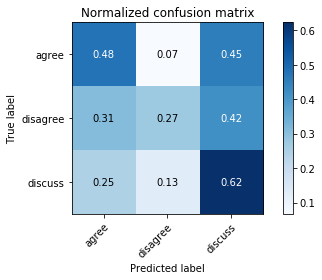

In [140]:
model = GradientBoostingClassifier(n_estimators = 500, subsample = 0.1, learning_rate = 0.01, random_state=0)
af1, pf1, tf1, vf1 = test_simple(model, [1,4,1])
plot_confusion_matrix_local(af1, pf1, classes=['agree', "disagree", 'discuss'], normalize=True)

Counter({'agree': 2547, 'discuss': 2541, 'disagree': 1960}) Counter({'discuss': 683, 'agree': 587, 'disagree': 132})
Training Baseline 36.14% Testing Baseline 48.72%
68.08% training accuracy
54.92% validation accuracy
Baseline comparison: TR 31.94% VAL 6.21%
F1 Score
[0.52517986 0.41975309 0.5994152 ]
Avg Precision Score
[0.55619048 0.35416667 0.59854015]
Normalized confusion matrix
[[0.49744463 0.11754685 0.38500852]
 [0.11363636 0.51515152 0.37121212]
 [0.31918009 0.08052709 0.60029283]]


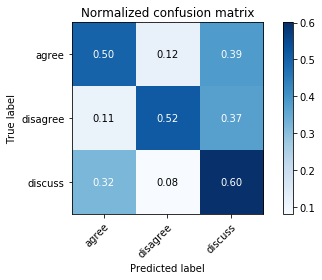

In [141]:
model2 = RandomForestClassifier(n_estimators = 400, max_depth = 7, min_samples_leaf = 3)
af2, pf2, tf2, vf2 = test_simple(model, [1,4,1])
plot_confusion_matrix_local(af2, pf2, classes=['agree', "disagree", 'discuss'], normalize=True)

Counter({'discuss': 2624, 'agree': 2531, 'disagree': 2008}) Counter({'agree': 603, 'discuss': 600, 'disagree': 120})
Training Baseline 36.63% Testing Baseline 45.58%
69.16% training accuracy
53.06% validation accuracy
Baseline comparison: TR 32.53% VAL 7.48%
F1 Score
[0.53641208 0.32608696 0.57073955]
Avg Precision Score
[0.57743786 0.28846154 0.55124224]
Normalized confusion matrix
[[0.50082919 0.09286899 0.40630182]
 [0.25833333 0.375      0.36666667]
 [0.31666667 0.09166667 0.59166667]]


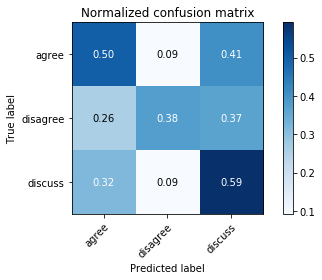

In [142]:
model3 = RandomForestClassifier(n_estimators = 400, max_depth = 7)
af3, pf3, tf3, vf3 = test_simple(model, [1,4,1])
plot_confusion_matrix_local(af3, pf3, classes=['agree', "disagree", 'discuss'], normalize=True)

## Final part of the pipeline: some more advanced models

In [206]:
def get_batch(data, i,batch_size):
    batches = data[0][i*batch_size:i*batch_size+batch_size]
    results = data[1][i*batch_size:i*batch_size+batch_size]
    results = [(2.0 if result == "agree" else (1.0 if result == "discuss" else 0.0)) for result in results]
    batches = np.array(batches)
    return np.swapaxes(batches, 0, 1),np.array(results)

In [207]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the MLP
        
        Args:
            x_in (torch.Tensor): an input data tensor 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the cross-entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate = F.relu(self.fc1(x_in))
        output = self.fc2(self.dropout(intermediate))
        return output

In [214]:
EMBEDDING_DIM = len(training_data[0][0])
HIDDEN_DIM = int(EMBEDDING_DIM/2)
OUTPUT_DIM = 2
DROPOUT = 0.3
num_epochs = 10
batch_size = 500

In [209]:
batches_train= int(len(training_data[1])/batch_size)
batches_val = int(len(testing_data[1])/batch_size)

mlp = MLP(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)
criterion = criterion = nn.CrossEntropyLoss()

In [216]:
def get_batch(data, targets, i,batch_size):
    batches = data[i*batch_size:i*batch_size+batch_size]
    results = targets[i*batch_size:i*batch_size+batch_size]
    results = [(1.0 if result == "agree" or result == "disagree" else 0.0) for result in results]
    batches = np.array(batches, dtype = "float")
    return batches, np.array(results)

def eval_model(model, data):
    correct = 0
    total = 0
    batch_x_test,batch_y_test = get_batch(data[0], data[1],0,len(stances_val))
    model.eval()
    predicted = None
    with torch.no_grad():
        inputs = Variable(torch.FloatTensor(batch_x_test))
        labels = torch.LongTensor(batch_y_test)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy: %d %%' % (100 * correct / total))
    return predicted

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

def train(model, total_batch, optimizer, criterion, data):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i in range(total_batch):
        batch_x,batch_y = get_batch(data[0], data[1],i, batch_size)
        #print(batch_x, batch_y)
        inputs = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        _, predicted = torch.max(predictions.data, 1)
        acc = binary_accuracy(predicted, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

def evaluate(model, total_batch, criterion, data):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for i in range(total_batch):
            batch_x,batch_y = get_batch(data[0], data[1],i,batch_size)
            inputs = Variable(torch.FloatTensor(batch_x))
            labels = Variable(torch.LongTensor(batch_y))
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            _, predicted = torch.max(predictions.data, 1)
            acc = binary_accuracy(predicted, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

In [217]:
start = time.time()
for epoch in range(num_epochs):

    train_loss, train_acc = train(mlp, batches_train, optimizer, criterion, training_data)
    valid_loss, valid_acc = evaluate(mlp, batches_val, criterion, testing_data)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')
end = time.time()
print(int(end-start))

| Epoch: 01 | Train Loss: 6.644 | Train Acc: 26.76% | Val. Loss: 5.261 | Val. Acc: 31.70% |
| Epoch: 02 | Train Loss: 6.578 | Train Acc: 26.87% | Val. Loss: 5.218 | Val. Acc: 31.70% |
| Epoch: 03 | Train Loss: 6.498 | Train Acc: 27.51% | Val. Loss: 5.176 | Val. Acc: 31.70% |
| Epoch: 04 | Train Loss: 6.609 | Train Acc: 26.35% | Val. Loss: 5.134 | Val. Acc: 31.70% |
| Epoch: 05 | Train Loss: 6.382 | Train Acc: 27.15% | Val. Loss: 5.093 | Val. Acc: 31.80% |
| Epoch: 06 | Train Loss: 6.398 | Train Acc: 26.51% | Val. Loss: 5.053 | Val. Acc: 31.90% |
| Epoch: 07 | Train Loss: 6.393 | Train Acc: 26.91% | Val. Loss: 5.013 | Val. Acc: 31.90% |
| Epoch: 08 | Train Loss: 6.387 | Train Acc: 26.60% | Val. Loss: 4.973 | Val. Acc: 31.90% |
| Epoch: 09 | Train Loss: 6.385 | Train Acc: 27.02% | Val. Loss: 4.934 | Val. Acc: 31.90% |
| Epoch: 10 | Train Loss: 6.191 | Train Acc: 26.75% | Val. Loss: 4.894 | Val. Acc: 31.90% |
0
